# Load datasets, drop uneeded columns

In [52]:
import pandas as pd

DATASET_PATH="/Users/eno/Datasets/"

# load the data
df_01_2019 = pd.read_csv(f'{DATASET_PATH}/flightlist_20190101_20190131.csv', low_memory=False)
df_03_2020 = pd.read_csv(f'{DATASET_PATH}/flightlist_20200401_20200430.csv')
df_10_2022 = pd.read_csv(f'{DATASET_PATH}/flightlist_20221001_20221031.csv')

#drop the columns we dont want anymore, and remove the NaN values from the relevant ones
df_19_cleaned = df_01_2019.drop(columns=["registration", "latitude_1", "longitude_1", "longitude_2", "latitude_2", "altitude_1", "altitude_2", "firstseen", "lastseen"])
df_20_cleaned = df_03_2020.drop(columns=["registration", "latitude_1", "longitude_1", "longitude_2", "latitude_2", "altitude_1", "altitude_2", "firstseen", "lastseen"])
df_22_cleaned = df_10_2022.drop(columns=["registration", "latitude_1", "longitude_1", "longitude_2", "latitude_2", "altitude_1", "altitude_2", "firstseen", "lastseen"])
df_19_cleaned = df_19_cleaned.dropna(subset=["origin", "destination", "day"])
df_20_cleaned = df_20_cleaned.dropna(subset=["origin", "destination", "day"])
df_22_cleaned = df_22_cleaned.dropna(subset=["origin", "destination", "day"])




# Filter just for air traffic to, from, or within the United States

In [46]:

#filter the resulting dataframes for only air traffic to, from, or within the United States
df_19_cleaned = df_19_cleaned[(df_19_cleaned["origin"].str.startswith("K")) | (df_19_cleaned["destination"].str.startswith("K"))]
df_20_cleaned = df_20_cleaned[(df_20_cleaned["origin"].str.startswith("K")) | (df_20_cleaned["destination"].str.startswith("K"))]
df_22_cleaned = df_22_cleaned[(df_22_cleaned["origin"].str.startswith("K")) | (df_22_cleaned["destination"].str.startswith("K"))]



# Filter just for the 10 busiest airports in the country

In [95]:
airport_codes = ["KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMIA"]

# create an empty dictionary to store the counts for each of the 3 years, as well as 2 dictionaries to store the percentages
airport_counts_20 = {}
airport_counts_22 = {}
airport_counts_19 = {}
change_dict_19_20 = {}
change_dict_20_22 = {}

# iterate over the airports and count the occurrences of each
for airport in airport_codes:
    count_2019 = ((df_19_cleaned["origin"] == airport) | (df_19_cleaned["destination"] == airport)).sum()
    count_2020 = ((df_20_cleaned["origin"] == airport) | (df_20_cleaned["destination"] == airport)).sum()
    count_2022 = ((df_22_cleaned["origin"] == airport) | (df_22_cleaned["destination"] == airport)).sum()
    #add the count recorded to the dictionary to store the counts
    airport_counts_19[airport] = count_2019
    airport_counts_20[airport] = count_2020
    airport_counts_22[airport] = count_2022

#iterate over the airports and calculate the difference between the counts for the years
for airport in airport_codes:
    change_20_22 = airport_counts_22[airport] - airport_counts_20[airport]
    change_19_20 = airport_counts_20[airport] - airport_counts_19[airport]
    #calculate the percentage change between 2019 and 2020 (pre-covid vs during covid), as well as for 2020 to 2022 (during covid vs post-covid)
    pct_change_19_20 = (change_19_20 / airport_counts_19[airport]) * 100
    pct_change_20_22 = (change_20_22 / airport_counts_20[airport]) * 100
    #add the calculated percentage to the dictionary, and convert it to a float for matplotlib
    change_dict_19_20[airport] = float("{:.2f}".format(pct_change_19_20))
    change_dict_20_22[airport] = float("{:.2f}".format(pct_change_20_22))

    # print(f'In March 2020 {airport} recorded {airport_counts_20[airport]} flights. In October 2022 it recorded {airport_counts_22[airport]}. This indicates a {pct_change_20_22:.2f}% change between 2020 and 2022')
    # print(f'In January 2019 {airport} recorded {airport_counts_19[airport]} flights. In March 2020 it recorded {airport_counts_20[airport]}. This indicates a {pct_change_19_20:.2f}% change between 2019 and 2020')



# Using matplotlib to visualize the data

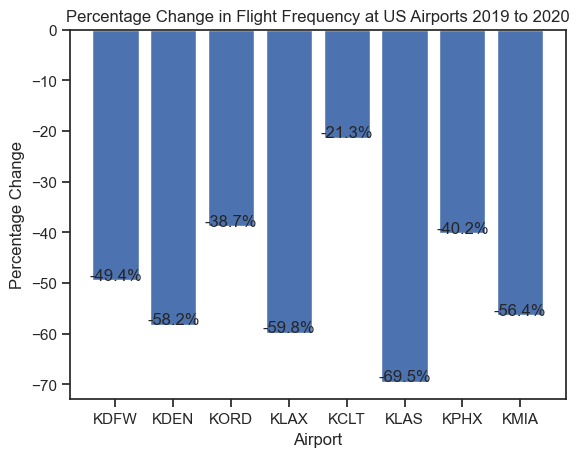

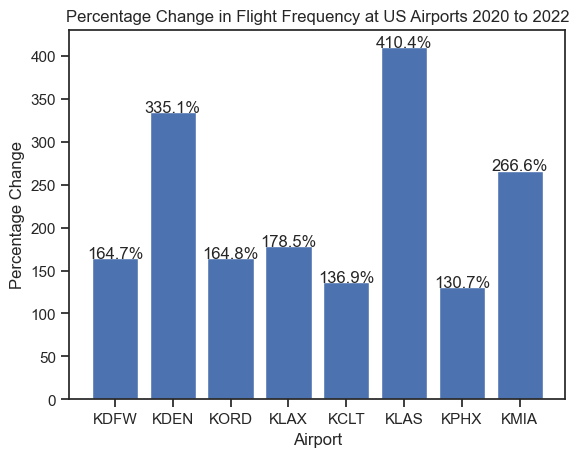

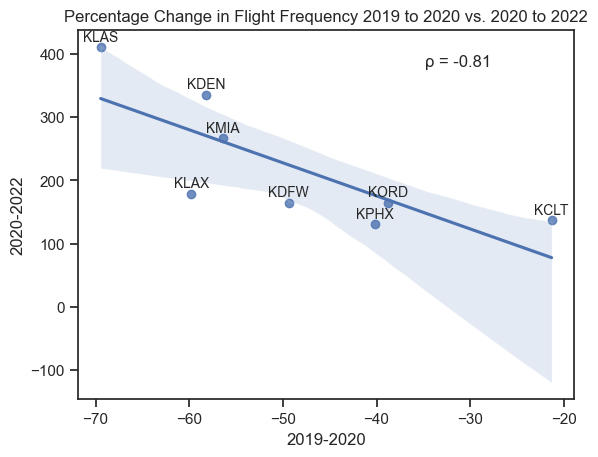

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

#create bar graph for percent change 2019 to 2020
plt.bar(change_dict_19_20.keys(), change_dict_19_20.values())
plt.xlabel('Airport')
plt.ylabel('Percentage Change')
plt.title('Percentage Change in Flight Frequency at US Airports 2019 to 2020')
for airport, change in change_dict_19_20.items():
    plt.text(airport, change, f"{change:.1f}%", ha='center')
plt.show()

#create a bar graph for percent change 2020 to 2022
plt.bar(change_dict_20_22.keys(), change_dict_20_22.values())
plt.xlabel('Airport')
plt.ylabel('Percentage Change')
plt.title('Percentage Change in Flight Frequency at US Airports 2020 to 2022')
for airport, change in change_dict_20_22.items():
    plt.text(airport, change, f"{change:.1f}%", ha='center')
plt.show()


# create 2 new dataframes from the percent change dictionaries
df1 = pd.DataFrame.from_dict(change_dict_19_20, orient='index', columns=['2019-2020'])
df2 = pd.DataFrame.from_dict(change_dict_20_22, orient='index', columns=['2020-2022'])

#concatenate them into one, replacing the index with the airport name 
df = pd.concat([df1, df2], axis=1).reset_index()
df = df.rename(columns={'index': 'Airport'})

#create a new df that has the spearman rho correlation coefficient matrix in it
corr_df = df.corr(method='spearman', numeric_only=True)
#extract the correct value and store it as a float
spearman_rho = "{:.2f}".format((corr_df.at['2020-2022', '2019-2020']))


#create the regplot using seaborn
sns.set(style='ticks')
plot = sns.regplot(x='2019-2020', y='2020-2022', data=df)
plt.title('Percentage Change in Flight Frequency 2019 to 2020 vs. 2020 to 2022')
# add an annotation with the correlation coefficient
plt.annotate(f'\u03C1 = {spearman_rho}', xy=(0.7, 0.9), xycoords='axes fraction')
#label all the points on the regplot with their associated airport
for i in range(len(df)):
    plot.text(df['2019-2020'][i], df['2020-2022'][i]+10, df['Airport'][i], ha='center', fontsize=10)
plt.show()




# Conclusions

The increase of air traffic at various airports post covid indicates that people are flying even more now than they were before covid. Additionally, given the spearman rho value of -0.81, it is clear that the change experienced from 2019-2020 is strongly correlated with the change experienced from 2020 to 2022. 